In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
#from torchinfo import summary
#from torchviz import make_dot
#from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torch.nn import functional as F
from torch import nn
SEED = 123

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams.update({'figure.dpi': 100})
mpl.rcParams.update({'figure.autolayout': False})
mpl.rcParams['mathtext.fontset'] = "cm"
mpl.rcParams['font.family'] = "DejaVu Serif"
mpl.rcParams['mathtext.fontset'] = "cm"
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

Bad value in file PosixPath('/home/daikiiwasaki/.config/matplotlib/stylelib/seaborn-darkgrid.mplstyle'), line 3 ('axes.facecolor: #EAEAF2'): Key axes.facecolor: '' does not look like a color arg


In [3]:
# デバイスの割り当て
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [9]:
from Model_train import torch_seed
from Model import Spectra_VAE, Spectra_CVAE

In [5]:
model = Spectra_VAE(latent_dim=4).eval()
modelfile =  ... # model file is too heavy to save git hub
model.load_state_dict(torch.load(modelfile,map_location=torch.device('cpu')))

<All keys matched successfully>

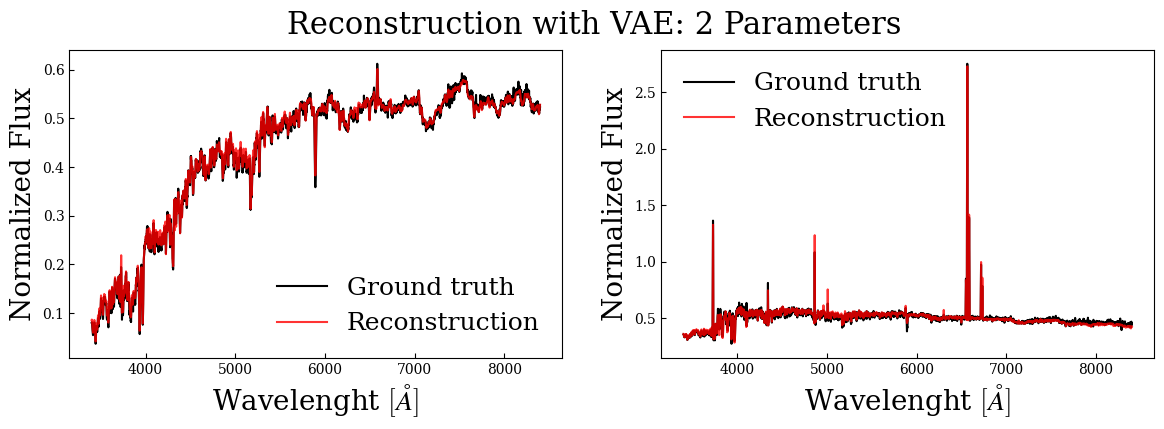

In [10]:
plt.figure(figsize=(14,4))
torch_seed()
plt.subplot(1,2,1)
wave_range = np.linspace(3400,8400,4000)
spectra = np.load('data/spectra_sample1.npy')
recon_spectra = model( torch.tensor(spectra).float() )[0][0].detach().numpy()
plt.plot(wave_range,spectra,c = 'k',label = 'Ground truth')
plt.plot(wave_range,recon_spectra,c = 'r',label = 'Reconstruction',alpha=0.8)
plt.xlabel('Wavelenght $[\AA]$',fontsize = 20)
plt.ylabel('Normalized Flux',fontsize=20)
plt.legend(fontsize=18,frameon=False)

plt.subplot(1,2,2)
wave_range = np.linspace(3400,8400,4000)
spectra = np.load('data/spectra_sample2.npy')
recon_spectra = model( torch.tensor(spectra).float() )[0][0].detach().numpy()
plt.plot(wave_range,spectra,c = 'k',label = 'Ground truth')
plt.plot(wave_range,recon_spectra,c = 'r',label = 'Reconstruction',alpha=0.8)
plt.xlabel('Wavelenght $[\AA]$',fontsize = 20)
plt.ylabel('Normalized Flux',fontsize=20)
plt.legend(fontsize=18,frameon=False)
plt.suptitle('Reconstruction with VAE: 2 Parameters',fontsize=22)
plt.savefig('Figure/Reconstruction_spectra.pdf',bbox_inches="tight",dpi=200)
plt.show()

In [11]:
from sklearn.decomposition import PCA
latent_test = np.load(f'data/Latent_variables_test.npy')
latent_train = np.load(f'data/Latent_variables_train.npy')
Pca = PCA(n_components=4,random_state=SEED)
Pca.fit(latent_train)

PCA(n_components=4, random_state=123)

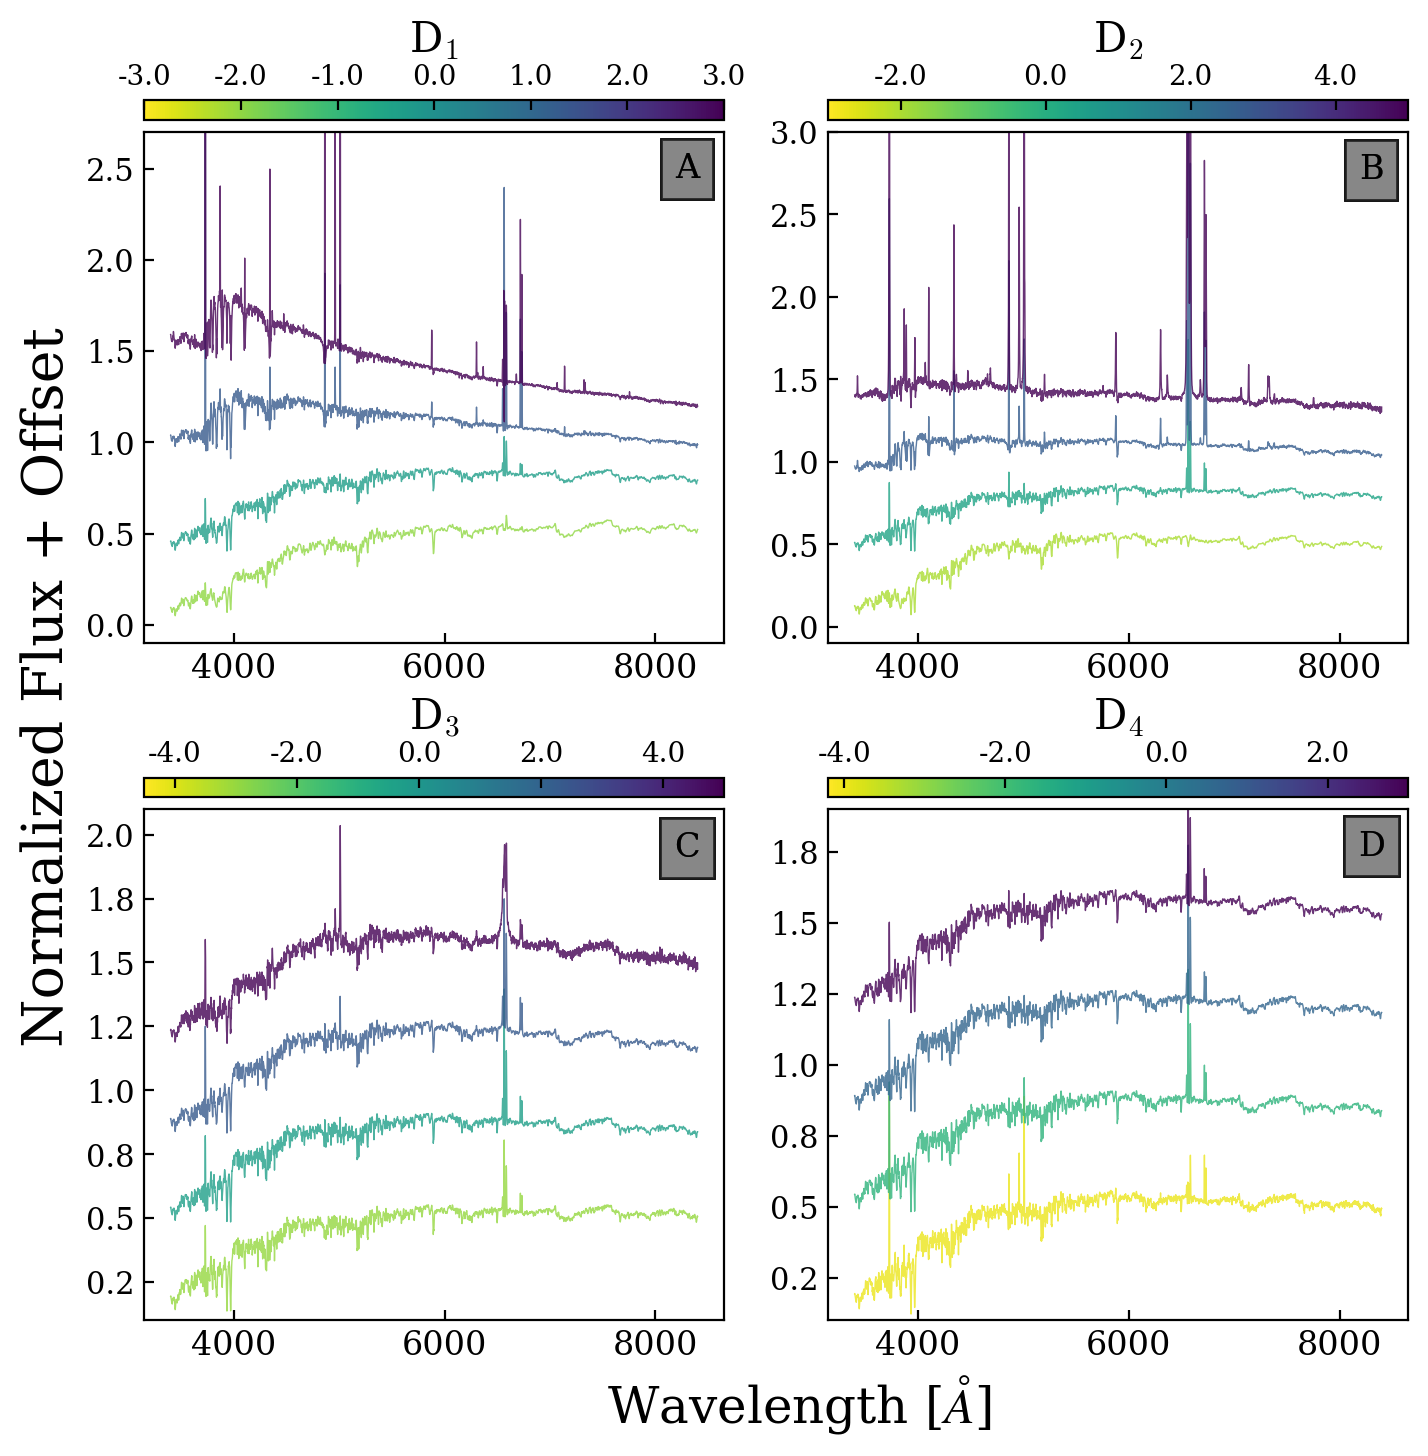

In [12]:
def coloring(val, allvals, colormap=plt.cm.viridis_r):
    min, max = np.nanmin(allvals, axis=-1), np.nanmax(allvals, axis=0)
    if np.isfinite(val):
        val = (val-min)/(max-min)
    else:
        val = np.nanmin(allvals, axis=-1)
    return colormap(val)
zw
import matplotlib.ticker as ticker
n_latent = 4
# from matplotlib.cm import ScalarMappable
cmap = plt.cm.viridis_r
model.eval()
torch_seed()
bins = 4
color_del = 1.5
x_col = 2
y_col = 2
wave_range = np.linspace(3400,8400,4000)
bottom = 0.3
fig, axes = plt.subplots(
    x_col,y_col,
    figsize=(7,7),dpi = 200,
)
plt.tight_layout()
plt.subplots_adjust(hspace=.1,wspace=0.18)

lim_list= [
    [-2, 3],
    [-2, 5],
    [-3, 5],
    [-4, 3]
]
y_lim_list = [
    [-.1,2.7],
    [-.1,3],
    [.1,2.1],
    [.1,1.9],
]
bottom = [
    0.3, 0.3, 0.35, 0.35
]
low_color = [
    -3, -3, -4.5, -4.2
]
ptext = [
    [8300,2.7],
    [8300,2.97],
    [8300,2.15],
    [8300,1.97],
]
cri = np.ones(4000,dtype=bool)
#cri = (wave_range > 4000) & (wave_range < 6000)
for j, i in enumerate( range(4) ):
    low, up = lim_list[i]
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=low_color[i], vmax=up))
    sm.set_array([])
    if x_col == 1 or y_col == 1:
        ax = axes[j]
    else:
        X = j // y_col
        Y = j % y_col
        ax = axes[X,Y]
    for cn, j in enumerate( np.linspace(low,up,bins) ):
        A = np.zeros((n_latent))
        A[i] = j
        A = Pca.inverse_transform(A)
        spe = model.decoder(torch.tensor(A).float())[0].detach().numpy()
        
        ax.plot(
            wave_range[cri],
            spe[cri]+cn*bottom[i], c = coloring(j,[low_color[i], up]),
            lw = .5,
            alpha = .8
        )
        ax.set_ylim( y_lim_list[i][0], y_lim_list[i][1] )
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.1f}'))
        # Set the font size for x-axis tick labels
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=11)

        # Add the text to the axes
        text = ax.text(ptext[i][0], ptext[i][1]-0.2, ['A','B','C','D'][i], ha='center', va='center', fontsize=12)

        # Set the background color of the text box
        text.set_bbox(dict(facecolor='gray', edgecolor='black', pad=5,alpha=0.5))

    if i == 2:
        a = 'Normalized Flux + Offset'
        ax.set_ylabel(a, fontsize=20, y=1.24)
        #ax.set_ylabel(a, fontsize=22)
        a = 'Wavelength [$\AA$]'
        ax.set_xlabel(a,fontsize = 18,x = 1.13)
        #ax.set_xlabel(a,fontsize = 18)
    cbar = plt.colorbar(
        sm,ax=ax,orientation='horizontal', pad=0.02,aspect = 30,location = 'top',
        format=ticker.FuncFormatter(lambda x, pos: f'{x:.1f}')
    )

    # Move the colorbar to the top of the figure
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
    cbar.set_label('D$_{}$'.format(i+1),fontsize = 15)
    cbar.ax.tick_params(labelsize=10)
plt.savefig('Figure/Spectra change VAE{} 1to4.pdf'.format(n_latent),bbox_inches="tight",dpi=200)
plt.show()

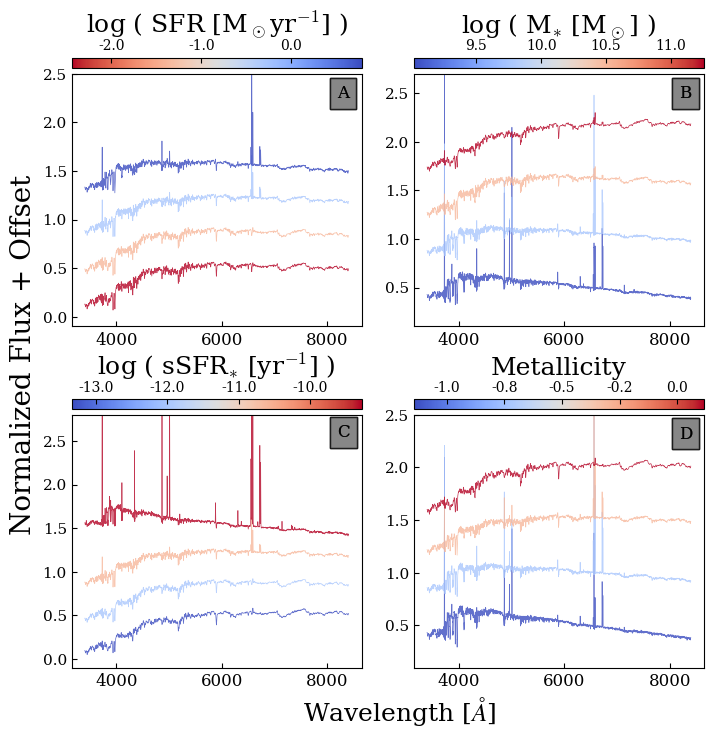

In [25]:
import matplotlib.ticker as ticker
from sklearn.preprocessing import PowerTransformer
scaler = PowerTransformer()
df_X2 = pd.read_csv('data/df_X2.csv',index_col=0)
n_latent = 4
torch_seed()
bins = 4
color_del = 1.5
x_col = 2
y_col = 2
wave_range = np.linspace(3400,8400,4000)
bottom = 0.3
fig, axes = plt.subplots(
    x_col,y_col,
    figsize=(7,7),dpi = 100,
)
plt.tight_layout()
plt.subplots_adjust(hspace=.12,wspace=0.18)

lim_list= np.array( [
    [-2, 2],
    [-2, 2],
    [-2, 2],
    [-2, 2]
] )
y_lim_list = np.array( [
    [-.1,2.5],
    [.1,2.7],
    [-.1,2.8],
    [.1,2.5],
])
bottom = [
    0.35, 0.55, 0.35, 0.5
]
low_color = [
    -2, -2, -2, -2
]
ptext = [
    [8300,2.5],
    [8300,2.7],
    [8300,2.8],
    [8300,2.52],
]
sigma = [
    15,15,10,2
]
Label = ['SFR','M','sSFR','Metal']
df_label = ['logSFR_SED','log_M*','logsSFR','exp_met']
Title = [
    'log ( SFR [M$_\odot$yr$^{-1}$] )',
     'log ( M$_{*}$ [M$_\odot$] )',
    'log ( sSFR$_{*}$ [yr$^{-1}$] )',
    'Metallicity',
]
cmaplist = [
    plt.cm.coolwarm_r,
    plt.cm.coolwarm,
    plt.cm.coolwarm,
    plt.cm.coolwarm,
]
cri = np.ones(4000,dtype=bool)
for j, i in enumerate( range(n_latent) ):
    n_latent = 1
    model = Spectra_CVAE(latent_dim=n_latent,n_class=1).eval()
    modelfile =  ... # model file is too heavy to save git hub
    model.load_state_dict(torch.load(modelfile, map_location=torch.device('cpu')))
    scaler.fit(df_X2[df_label[i]].values.reshape(-1, 1))
    low, up = scaler.inverse_transform( lim_list[i].reshape(-1, 1) )
    sm = plt.cm.ScalarMappable(cmap=cmaplist[j], norm=plt.Normalize(vmin=scaler.inverse_transform( np.array( low_color[i]).reshape(-1, 1) )[0][0], vmax=up))
    sm.set_array([])
    if x_col == 1 or y_col == 1:
        ax = axes[j]
    else:
        X = j // y_col
        Y = j % y_col
        ax = axes[X,Y]
    for cn, j in enumerate( np.linspace(low,up,bins) ):
        A = np.zeros((1,n_latent+1))
        A[0][n_latent] = scaler.transform( np.array(j).reshape(-1, 1) )[0][0]
        spe = model.decoder(torch.tensor(A).float())[0].detach().numpy()
        ax.plot(
            wave_range[cri],
            spe[cri]+cn*bottom[i], c = coloring(j,[scaler.inverse_transform( np.array( low_color[i]).reshape(-1, 1) )[0][0], up[0]],colormap=cmaplist[i]),
            lw = .5,
            alpha = .8
        )
        ax.set_ylim( y_lim_list[i][0], y_lim_list[i][1] )
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.1f}'))
        # Set the font size for x-axis tick labels
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=11)

        # Add the text to the axes
        text = ax.text(ptext[i][0], ptext[i][1]-0.2, ['A','B','C','D'][i], ha='center', va='center', fontsize=12)

        # Set the background color of the text box
        text.set_bbox(dict(facecolor='gray', edgecolor='black', pad=5,alpha=0.5))

    if i == 2:
        a = 'Normalized Flux + Offset'
        ax.set_ylabel(a, fontsize=20, y=1.24)
        #ax.set_ylabel(a, fontsize=22)
        a = 'Wavelength [$\AA$]'
        ax.set_xlabel(a,fontsize = 18,x = 1.13)
        #ax.set_xlabel(a,fontsize = 18)
    cbar = plt.colorbar(
        sm,ax=ax,orientation='horizontal', pad=0.02,aspect = 30,location = 'top',
        format=ticker.FuncFormatter(lambda x, pos: f'{x:.1f}')
    )

    # Move the colorbar to the top of the figure
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
    cbar.set_label(Title[i],fontsize = 18)
    cbar.ax.tick_params(labelsize=10)
plt.savefig('Figure/Spectra change CVAE{} 1to4.pdf'.format(n_latent),bbox_inches="tight",dpi=200)
plt.show()